<a href="https://colab.research.google.com/github/pratik-poudel/financial_news_stock/blob/master/1%20positive%20negative%20final%2065.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlxtend --upgrade

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional,LSTM, GlobalMaxPool1D, Dense
from tensorflow.keras.utils import to_categorical, plot_model


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score,precision_recall_fscore_support
from sklearn.utils import resample, shuffle


from mlxtend.plotting import plot_confusion_matrix
import warnings 
warnings.filterwarnings('ignore')

# Financial Phrase Bank 

In [82]:
fin_data = pd.read_table('/content/Sentences_50Agree.txt', delimiter='\r\n')

In [83]:
values = np.array([fin_data.values[i][0].split('@') for i in range(fin_data.shape[0])])
data = pd.DataFrame({'sentence': values[:, 0], 'sentiment':values[:, 1]})

In [84]:
data.head(2)

,sentence,sentiment
0,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",neutral
1,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .",negative


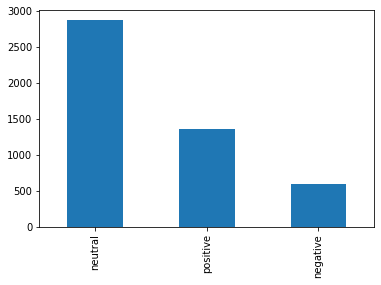

In [85]:
data['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [98]:
X= data.sentence
y = data.sentiment
neu = y[y == 'neutral'].index
X= X.drop(neu)
y = y.drop(neu)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=60, test_size=0.2)

In [99]:
X_train.shape, X_test.shape, X.shape

((1573,), (394,), (1967,))

In [100]:
# neu_index = y_train[y_train == 'neutral'].index
pos_index = y_train[y_train == 'positive'].index
neg_index = y_train[y_train == 'negative'].index

In [101]:

# Down-sample neutral class
# X_train_neu, y_train_neu = resample(X_train.loc[neu_index], y_train.loc[neu_index],
#                                     n_samples=len(pos_index), replace=False,
#                                     random_state=60)

# Up-sample negative class
X_train_neg, y_train_neg = resample(X_train.loc[neg_index], y_train.loc[neg_index],
                                    n_samples=len(pos_index), replace=True,
                                    random_state=60)

In [11]:
# # Combine resampled classes
# X_train_resample = X_train.loc[pos_index].append([X_train_neu, X_train_neg])
# y_train_resample = y_train.loc[pos_index].append([y_train_neu, y_train_neg])

# # Shuffle samples
# X_train_resample, y_train_resample = shuffle(X_train_resample, y_train_resample, random_state=7)

# # Display new class counts
# print(y_train_resample.value_counts())

neutral     1090
negative    1090
positive    1090
Name: sentiment, dtype: int64


In [102]:
X_train = X_train.loc[pos_index].append(X_train_neg)
y_train = y_train.loc[pos_index].append(y_train_neg)
X_train, y_train = shuffle(X_train, y_train, random_state=60)

In [103]:
y_test.value_counts()

positive    273
negative    121
Name: sentiment, dtype: int64

# Prepare Data for model

In [104]:
# Remove Punctuation and assign integer to each word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [105]:
# Make sequences of equal length 
max_len = np.max([len(X_train_seq[i]) for i in range(len(X_train_seq))])
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len)

In [106]:
max_len

53

In [118]:
# Convert sentiment values to one hot encoded for Keras model
le = LabelEncoder()
le.fit(y_train)
y_train_seq = to_categorical(le.transform(y_train))
y_test_seq = to_categorical(le.transform(y_test))

In [119]:
le.classes_

array(['negative', 'positive'], dtype=object)

# EMBEDDINGS

In [16]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

--2021-03-21 03:31:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-21 03:31:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-21 03:31:05--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [109]:
dict_w2v = {}
with open('/content/glove.6B.100d.txt', 'r') as file:
    for line in file:
        tokens = line.split()
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)
        if vector.shape[0] == 100:
            dict_w2v[word] = vector
        else:
            print("There is issue with " + word)

In [110]:
print("dictionary size :" ,len(dict_w2v) )

dictionary size : 400000


In [111]:
words_found = set()
words_not_found = set()
for word in tokenizer.word_index:
    vec = dict_w2v.get(word)
    if vec is not None:
        words_found.add(word)
    else:
        words_not_found.add(word)
len(words_found), len(words_not_found), len(tokenizer.word_index)

(4273, 551, 4824)

In [112]:
EMBEDDING_DIM = 100
VOCAB_SIZE = len(tokenizer.word_index)
embedding_matrix = np.zeros((VOCAB_SIZE +1, EMBEDDING_DIM))

In [113]:
unk_cnt = 0
unk_set = set()
for word, i in tokenizer.word_index.items():
    emb_vector = dict_w2v.get(word)
    if emb_vector is not None:
        embedding_matrix[i] = emb_vector
    else:
        unk_cnt += 1
        unk_set.add(word)
unk_cnt

551

In [114]:
X_train_seq.shape, y_train_seq.shape

((2180, 53), (2180,))

Epoch 1/100
35/35 [==============================] - 4s 33ms/step - loss: 0.7291 - recall: 0.5434 - val_loss: 0.9386 - val_recall: 0.3553
Epoch 2/100
35/35 [==============================] - 0s 13ms/step - loss: 0.5972 - recall: 0.6956 - val_loss: 0.9356 - val_recall: 0.4010
Epoch 3/100
35/35 [==============================] - 0s 14ms/step - loss: 0.5328 - recall: 0.7372 - val_loss: 1.2480 - val_recall: 0.4213
Epoch 4/100
35/35 [==============================] - 0s 14ms/step - loss: 0.5115 - recall: 0.7633 - val_loss: 0.8228 - val_recall: 0.5330
Epoch 5/100
35/35 [==============================] - 0s 14ms/step - loss: 0.4618 - recall: 0.7753 - val_loss: 0.5527 - val_recall: 0.7081
Epoch 6/100
35/35 [==============================] - 0s 14ms/step - loss: 0.4098 - recall: 0.8071 - val_loss: 0.5744 - val_recall: 0.6878
Epoch 7/100
35/35 [==============================] - 0s 13ms/step - loss: 0.4009 - recall: 0.8226 - val_loss: 0.7915 - val_recall: 0.5685
Epoch 8/100
35/35 [===============

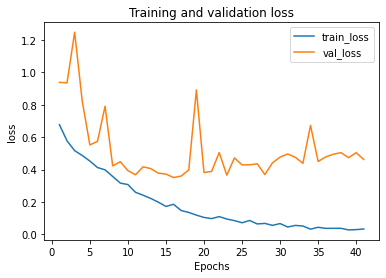

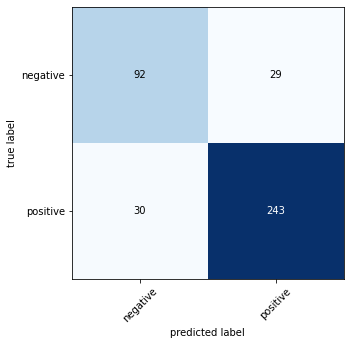

          1-Precision  2-Recall  3-F1 score  4-Support
negative  0.754        0.76      0.757       121      
positive  0.893        0.89      0.892       273      


In [120]:
np.random.seed(60)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(VOCAB_SIZE +1, EMBEDDING_DIM, weights=[embedding_matrix],input_length=max_len, trainable=False))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='concat')) #{"sum", "mul", "ave", "concat", None}
model.add(Dropout(0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[ 
                                                                            #  'Precision',                                                        
                                                                             'Recall',
                                                                            #  'accuracy'
                                                                             ])
# model.summary()

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')


batch_size = 64
epochs = 100


history = model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size,verbose=1, validation_data=(X_test_seq, y_test_seq), 
                    callbacks=[early_stopping, mcp_save], shuffle=False)


%matplotlib inline
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history, 'loss')


model.load_weights('model.hdf5')

preds = model.predict(X_test_seq, batch_size=batch_size)
true_y = np.argmax(y_test_seq, axis=1)
pred_y = np.argmax(preds, axis=1)

c_mat = confusion_matrix(true_y, pred_y)
plot_confusion_matrix(c_mat, cmap='Blues', class_names = le.classes_, figsize=(5, 5))
plt.show()

p, r, f1, s = precision_recall_fscore_support(true_y, pred_y, average=None)

# Print precision, recall, f1 score and support
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)

# Print precision, recall, f1 score and support
print(results.round(decimals=3))

# Prepare NEPSE DATA

In [121]:
indices = pd.read_csv('/content/Nepse Indices - Sheet1.csv', header=1)
indices.columns= ['no_name', 'date', 'index', 'abs_change', 'pct_change']
indices['date'] = pd.to_datetime(indices['date'])
indices = indices[indices['date'] < '2019-07-06']

In [122]:
news_df = pd.read_csv('/content/years_combined_df.csv')
news_df['date'] = pd.to_datetime(news_df['date'])
news_df = news_df[news_df['date'] >= '2014-02-02']
news_df.reset_index(drop=True, inplace=True)
print("Total News Data Scraped :", news_df.shape[0])

Total News Data Scraped : 9802


In [123]:
news_df = news_df[news_df['date'].isin(indices['date'])].reset_index(drop=True)
print("Total News Data as per Nepse indices trading days ", news_df.shape[0])

Total News Data as per Nepse indices trading days  6307


In [124]:
print("Total NEPSE Index days: ", indices.shape[0])

Total NEPSE Index days:  1248


In [125]:
indices = indices[indices['date'].isin(news_df['date'])].reset_index(drop=True)
print("Total NEPSE index matched with News date:", indices.shape[0])

Total NEPSE index matched with News date: 1238


In [126]:
indices['pct_change'] = indices['pct_change'].str.replace('%', '').astype(float)

In [127]:
indices['target'] = np.where(indices['pct_change'] < 0 , 0, 1)

In [128]:
def prepare_and_predict_news(series, pad_max_len, batch_size):

    news = tokenizer.texts_to_sequences(series)
    news = pad_sequences(news, pad_max_len)
    news = model.predict(news, batch_size=batch_size)
    return news

In [130]:
news_sentiment = prepare_and_predict_news(news_df['content'], pad_max_len=max_len, batch_size=batch_size)
# news_df['pred_glove_300'] = np.argmax(news_sentiment, axis=1)

In [131]:
news_sentiment_df = pd.DataFrame(news_sentiment, columns=['negative', 'positive'])

In [132]:
final_df = pd.concat([news_df, news_sentiment_df], axis=1)

In [134]:
for i, j in final_df[:2].iterrows():
    print(i, j.content, j.negative, j.positive)

0 Nepal Stock Exchange (Nepse) slid 2.22 points to close at 781.46 points last week. 0.9489344358444214 0.05106557905673981
1 Moffat Nyirenda is president of Round Table International. 0.08581293374300003 0.9141870737075806


In [136]:
pd.set_option('max_colwidth', -1)
final_df[['content', 'negative', 'positive']].head(15)

,content,negative,positive
0,Nepal Stock Exchange (Nepse) slid 2.22 points to close at 781.46 points last week.,0.948934,0.051066
1,Moffat Nyirenda is president of Round Table International.,0.085813,0.914187
2,The government has stopped monitoring of shops dealing in readymade garment and shoes although previous inspections have revealed rampant malpractices.,0.754388,0.245612
3,The Ministry of Industry (MoI) is preparing to recommend the Cabinet to declare Pokhara-based Fulbari Resort and Chitwan-based Chitwan Wildlife Lodge,0.048945,0.951055
4,The delivery of Chinese aircraft for Nepal Airlines Corporation (NAC) will be delayed by a month.,0.930788,0.069212
5,"Talking about pricey threads, the domestic market will soon get to witness the launch of a suiting brand costing upwards of Rs 300,000.",0.055627,0.944373
6,Cross-border trade with India via Janakpur has come to a complete halt after Janakpur Railway suspended its Janakpur-Jayanagar service.,0.002880,0.997120
7,Fifty-seven percent work has been completed on the much-prioritised 456-MW Upper Tamakoshi Hydropower Project (UTHP).,0.004524,0.995476
8,The government is not in a position to assure the quality of cooking oil due to the lack of technology to determine the quantity of different components of the oil.,0.005989,0.994011
9,NIDC Development Bank won’t be able to hand out the promised 133 percent bonus shares as it has not issued public shares yet.,0.650285,0.349715


In [137]:
df = pd.merge(final_df, indices, left_on='date', right_on='date')

In [138]:
indices['negative_mean'] = df.groupby('date')['negative'].apply(np.mean).reset_index(drop=True)
# indices['neutral_mean'] = df.groupby('date')['neutral'].apply(np.mean).reset_index(drop=True)
indices['positive_mean'] = df.groupby('date')['positive'].apply(np.mean).reset_index(drop=True)

In [139]:
features = ['negative_mean', 'positive_mean']

In [187]:
validation_df = indices[indices['date'] > '2018-12-31']
train_df = indices[indices['date'] <= '2018-12-31']

In [188]:
Xtrain, ytrain = train_df[features], train_df['target']

In [189]:
Xtest, ytest = validation_df[features], validation_df['target']

In [191]:
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((1117, 2), (1117,), (121, 2), (121,))

In [225]:
def accuracy_metrics(preds, dtrain):

    labels = dtrain.get_label()
    # print(labels)
    # preds = preds.reshape(5, -1).T
    preds = np.round(preds)
    # f_score = f1_score(labels , preds,  average = 'weighted')
    acc_score = accuracy_score(labels, preds)
    return 'acc_score', acc_score, True

In [226]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(train_df[features], train_df['target'],
#                                                 stratify=train_df['target'],
#                                                 random_state=60, test_size=0.2 )


params = {
'num_leaves': 4,
'objective': 'binary',
'max_depth': 4,
'learning_rate': 0.05,
"boosting_type": "gbdt",
"bagging_seed": 11,
# "metric": 'auc',
"verbosity": -1,
'random_state': 60
}
import lightgbm as lgb
tr_data = lgb.Dataset(Xtrain, label=ytrain)
va_data = lgb.Dataset(Xtest, label=ytest)

model = lgb.train(
        params, 
        tr_data,
        num_boost_round=5000,   
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,
        feval=accuracy_metrics,   
        feature_name=features,
        verbose_eval=10
    )


Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.68697	training's acc_score: 0.559534	valid_1's binary_logloss: 0.69132	valid_1's acc_score: 0.528926
[20]	training's binary_logloss: 0.682777	training's acc_score: 0.57744	valid_1's binary_logloss: 0.691147	valid_1's acc_score: 0.578512
[30]	training's binary_logloss: 0.679781	training's acc_score: 0.57744	valid_1's binary_logloss: 0.690734	valid_1's acc_score: 0.578512
[40]	training's binary_logloss: 0.676333	training's acc_score: 0.595345	valid_1's binary_logloss: 0.688284	valid_1's acc_score: 0.603306
[50]	training's binary_logloss: 0.673284	training's acc_score: 0.602507	valid_1's binary_logloss: 0.687279	valid_1's acc_score: 0.603306
[60]	training's binary_logloss: 0.671376	training's acc_score: 0.602507	valid_1's binary_logloss: 0.684708	valid_1's acc_score: 0.603306
[70]	training's binary_logloss: 0.66962	training's acc_score: 0.607878	valid_1's binary_logloss: 0.683694	valid_1's acc_

In [227]:
model.best_iteration

33

In [142]:
# !pip install optuna

In [246]:
import optuna
from sklearn.metrics import roc_auc_score
from google.colab import output
# lgb_train = lgb.Dataset(Xt, Yt)
# lgb_eval = lgb.Dataset(Xv, Yv)
def objective(trial):    
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 2, 512),
            'boosting_type': 'gbdt',
            'objective': 'binary',
            # 'metric': 'auc',
            'max_depth': trial.suggest_int('max_depth', 1, 16),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 80),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
            'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'max_bin': trial.suggest_int('max_bin', 4, 900),
            'early_stopping_rounds': 50,
            'random_state':60 
            }

    model = lgb.train(params, tr_data, valid_sets=[tr_data, va_data], verbose_eval=None, num_boost_round=5000, feval=accuracy_metrics)
    score = model.best_score['valid_1']['acc_score']
    # val_pred = model.predict(Xtest)
    # score = accuracy_score(ytest, np.round(val_pred))
    output.clear()
    # print(f"AUC = {score}")
    return score

In [248]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2021-03-21 05:11:14,222] Trial 999 finished with value: 0.5702479338842975 and parameters: {'num_leaves': 27, 'max_depth': 1, 'min_child_weight': 4, 'feature_fraction': 0.8141465062952846, 'bagging_fraction': 0.6016486872644486, 'bagging_freq': 3, 'min_child_samples': 22, 'lambda_l1': 0.014059420465324447, 'lambda_l2': 2.15496297739647e-06, 'learning_rate': 0.49433773634960687, 'max_bin': 511}. Best is trial 180 with value: 0.6611570247933884.


In [249]:
study.best_params

{'bagging_fraction': 0.6190267199063966,
 'bagging_freq': 6,
 'feature_fraction': 0.6215938415157346,
 'lambda_l1': 0.0010998836403125192,
 'lambda_l2': 7.734490471406515e-07,
 'learning_rate': 0.45705008426586125,
 'max_bin': 688,
 'max_depth': 1,
 'min_child_samples': 19,
 'min_child_weight': 4,
 'num_leaves': 77}

In [250]:

import lightgbm as lgb
tr_data = lgb.Dataset(Xtrain, label=ytrain)
va_data = lgb.Dataset(Xtest, label=ytest)
params = {
'objective': 'binary',
"boosting_type": "gbdt",
# "metric": 'auc',
"verbosity": -1,
'random_state': 60,

 'bagging_fraction': 0.6190267199063966,
 'bagging_freq': 6,
 'feature_fraction': 0.6215938415157346,
 'lambda_l1': 0.0010998836403125192,
 'lambda_l2': 7.734490471406515e-07,
 'learning_rate': 0.45705008426586125,
 'max_bin': 688,
 'max_depth': 1,
 'min_child_samples': 19,
 'min_child_weight': 4,
 'num_leaves': 77
}



model = lgb.train(
        params, 
        tr_data,
        num_boost_round=5000,   
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,   
        feature_name=features,
        verbose_eval=10, 
        feval = accuracy_metrics
    )


Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.686844	training's acc_score: 0.536258	valid_1's binary_logloss: 0.69095	valid_1's acc_score: 0.512397
[20]	training's binary_logloss: 0.68317	training's acc_score: 0.547896	valid_1's binary_logloss: 0.683634	valid_1's acc_score: 0.603306
[30]	training's binary_logloss: 0.680722	training's acc_score: 0.574754	valid_1's binary_logloss: 0.679001	valid_1's acc_score: 0.644628
[40]	training's binary_logloss: 0.680349	training's acc_score: 0.571173	valid_1's binary_logloss: 0.700655	valid_1's acc_score: 0.545455
[50]	training's binary_logloss: 0.676338	training's acc_score: 0.592659	valid_1's binary_logloss: 0.673323	valid_1's acc_score: 0.603306
[60]	training's binary_logloss: 0.675176	training's acc_score: 0.588183	valid_1's binary_logloss: 0.675589	valid_1's acc_score: 0.595041
[70]	training's binary_logloss: 0.673846	training's acc_score: 0.583706	valid_1's binary_logloss: 0.680366	valid_1's a

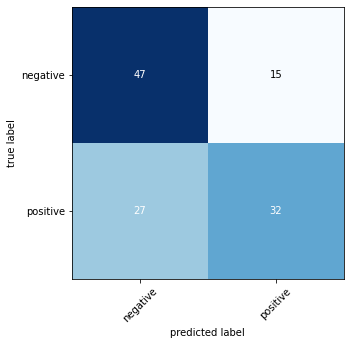

          1-Precision  2-Recall  3-F1 score  4-Support
negative  0.635        0.758     0.691       62       
positive  0.681        0.542     0.604       59       
0.6081191908146528
0.6528925619834711


In [252]:
preds = model.predict(Xtest, num_iteration=model.best_iteration)
c_mat = confusion_matrix(ytest, np.round(preds))
plot_confusion_matrix(c_mat, cmap='Blues', class_names = le.classes_, figsize=(5, 5))
plt.show()

p, r, f1, s = precision_recall_fscore_support(ytest, np.round(preds), average=None)

results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)
print(results.round(decimals=3))
print(roc_auc_score(ytest, preds))
print(accuracy_score(ytest, np.round(preds)))

In [174]:
model.predict(Xtest)

array([0.49690984, 0.55690124, 0.49690984, 0.50822257, 0.50822257,
       0.37411674, 0.52860535, 0.45406618, 0.36382066, 0.39106047,
       0.42502663, 0.39106047, 0.42502663, 0.41286268, 0.50642029,
       0.57983289, 0.51804538, 0.43859673, 0.39589675, 0.51804538,
       0.51804538, 0.51804538, 0.52860535, 0.49336754, 0.45406618,
       0.51804538, 0.36382066, 0.51804538, 0.50822257, 0.45406618,
       0.51804538, 0.42502663, 0.37221021, 0.36382066, 0.48992668,
       0.55690124, 0.45406618, 0.57983289, 0.48992668, 0.49690984,
       0.55690124, 0.36382066, 0.51804538, 0.67715956, 0.67715956,
       0.52996983, 0.57983289, 0.42484646, 0.55690124, 0.45406618,
       0.50642029, 0.46358013, 0.46921617, 0.50822257, 0.42502663,
       0.59475209, 0.67715956, 0.52860535, 0.57983289, 0.4157156 ,
       0.55690124, 0.51804538, 0.54985293, 0.42502663, 0.42502663,
       0.55964655, 0.51804538, 0.49690984, 0.60955007, 0.50822257,
       0.45096417, 0.48167171, 0.39106047, 0.51804538, 0.50822

In [152]:
accuracy_score(ytest, np.round(model.predict(Xtest)))

0.6026785714285714

In [153]:
roc_auc_score(ytest, model.predict(Xtest))

0.6093338651775029

In [154]:
roc_auc_score(validation_df['target'], model.predict(validation_df[features]))

0.5334882449425915

In [155]:
accuracy_score(validation_df['target'], np.round(model.predict(validation_df[features])))

0.5371900826446281